In [ ]:
!pip install transformers==4.5.1

In [5]:
import transformers
import pickle
import statistics 
import torch
import seaborn as sns
from scipy import stats
from scipy import spatial
from sklearn.manifold import MDS
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import csv
import plotly.graph_objects as go
import plotly.express as px

In [9]:
#Below are the variables for running the data analysis.
#ptweightsPath: path to the pickled sieve bias scores for the 1000 sentences in each of the six languages for the pretrained model.
#ftweightsPath: path to the pickled sieve bias scores for the 1000 sentences in each of the six languages for the fine tuned model.
#analysisPath: path to store the analysis plots, figures etc.
#threshold: Threshold to be used for the statistical tests.
#n: Number of sentences

ptweightsPath='/content/drive/My Drive/MTP/Weights/'
ftweightsPath='/content/drive/My Drive/MTP/Weights/XNLI/'
analysisPath='/content/drive/My Drive/MTP/Analytics/'
threshold=3
n=1000
functionspos=['cls','sep','local']
functionssyn=['nsubj','amod','advmod','obj']

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Plot the P-scores Heatmaps - pretrained model**

In [ ]:
#To find the p-scores lying outside the range (0.05,0.95). This cell can also be used to plot the heatmaps of p-scores, by uncommenting the below lines.

languages=['english','german','french','spanish','hindi','urdu']

functions=['cls','sep','local','nsubj','amod','advmod','obj']

count=0
for lang in languages:
  for func in functions:
    with open(ptweightsPath + lang + '-matrix-' + func + '-1000.pl', 'rb') as f:
        headSentScores=pickle.load(f)

    pScores=[]

    for i in range(1,145):
        s=statistics.stdev(headSentScores[i])
        m=statistics.mean(headSentScores[i])
        t=(m-threshold)/(s/math.sqrt(n))
        p=stats.t.sf(t, n-1)
        if(p>0.05 and p<0.95):
          count+=1
        pScores.append(p)

    # array=np.array(pScores).reshape(12,12)

    # array=np.round(array, 2)

    # graph = sns.heatmap(array, cmap='Oranges', annot=array, linewidth=1)

    # graph.set_xticks(np.arange(2,13,2))
    # graph.set_xticklabels(np.arange(2,13,2),fontdict={'size':15})
    # graph.set_yticks(np.arange(2,13,2))
    # graph.set_yticklabels(np.arange(2,13,2),fontdict={'size':15})

    # graph.set_xlabel('Heads',fontdict={'size':15})
    # graph.set_ylabel('Layers',fontdict={'size':15})

    # plt.gca().invert_yaxis()
    # plt.savefig(analysisPath + 'Plots/PreTrained/' + func + '-pscores.pdf', dpi=1200, format='pdf',bbox_inches='tight')
    # plt.clf()

print(count/(144*len(languages)*len(functions)))

0.027281746031746032


**Spearman correlation for each head, across pairs of languages in the pretrained model**

In [ ]:
#This cell computes the mean spearman correlation for language pairs using the syntactic sieve scores.

languages=['english','german','french','spanish','hindi','urdu']

functions=['nsubj','amod','advmod','obj']

scores=np.array([[0 for i in range(15)] for j in range(0,145)],dtype=float)

print(scores.shape)

col=0

for i in range(len(languages)):
  for j in range(i+1,len(languages)):

    headScores1=np.array([[0 for i in range(len(functions))] for j in range(0,145)],dtype=float)
    headScores2=np.array([[0 for i in range(len(functions))] for j in range(0,145)],dtype=float)

    for index,k in enumerate(functions):
      with open(ptweightsPath + languages[i]+ '-matrix-' + k + '-1000.pl', 'rb') as f:
        headSentScores1=pickle.load(f)
      with open(ptweightsPath + languages[j] + '-matrix-' + k + '-1000.pl', 'rb') as f:
        headSentScores2=pickle.load(f)

      sieveScores1=[]
      sieveScores2=[]

      for p in range(1,145):
        m1=statistics.mean(headSentScores1[p])
        m2=statistics.mean(headSentScores2[p])
        sieveScores1.append(m1)
        sieveScores2.append(m2)

      sieveScores1=np.array([0]+sieveScores1)
      sieveScores2=np.array([0]+sieveScores2)

      headScores1[:,index]=sieveScores1
      headScores2[:,index]=sieveScores2

    for k in range(1,145):
      scores[k][col]=stats.spearmanr(headScores1[k],headScores2[k])[0]
    
    col+=1

    print(i,j)

pairs=[]

for i in range(len(languages)):
    for j in range(i+1,len(languages)):
      pairs.append(languages[i].title() + '-' + languages[j].title())

df=pd.DataFrame([np.mean(scores,axis=0)],columns=pairs)

print(df.T)

(145, 15)
0 1
0 2
0 3
0 4
0 5
1 2
1 3
1 4
1 5
2 3
2 4
2 5
3 4
3 5
4 5
                        0
English-German   0.718621
English-French   0.684138
English-Spanish  0.641379
English-Hindi    0.554483
English-Urdu     0.518621
German-French    0.518621
German-Spanish   0.531034
German-Hindi     0.630345
German-Urdu      0.656552
French-Spanish   0.776552
French-Hindi     0.504828
French-Urdu      0.457931
Spanish-Hindi    0.573793
Spanish-Urdu     0.533793
Hindi-Urdu       0.824828


**Average number of delimiter heads across languages - pretrained model**

In [ ]:
#This cell computes the average percentage of delimiter heads across the languages in the pretrained model.

languages=['english','german','french','spanish','hindi','urdu']

functions=['cls','sep']

avg=0

for i in range(len(languages)):
  heads=set()
  for index,k in enumerate(functions):
    with open(ptweightsPath + languages[i]+ '-matrix-' + k + '-1000.pl', 'rb') as f:
        headSentScores=pickle.load(f)

    for p in range(1,145):
        s=statistics.stdev(headSentScores[p])
        m=statistics.mean(headSentScores[p])
        t=(m-threshold)/(s/math.sqrt(n))
        pval=stats.t.sf(t, n-1)
        if(pval<0.05):
          heads.add(p)

  print(len(heads))
  avg+=len(heads)/144
    
print('Average percentage of delimiter heads ',round((avg/len(languages))*100))

89
94
97
102
107
101
Average percentage of delimiter heads  68


**Overlap between local and syntactic heads in the pretrained model**

In [ ]:
#This cell computes the average overlap of syntactic heads with local heads in pretrained mBERT.

languages=['english','german','french','spanish','hindi','urdu']

functions=['nsubj','amod','advmod','obj']

avg=0

count=0
for i in range(len(languages)):
  common=set()
  for k in functions:
    with open(ptweightsPath + languages[i]+ '-matrix-' + k + '-1000.pl', 'rb') as f:
        headSentScores=pickle.load(f)

    heads=[]
    for p in range(1,145):
        s=statistics.stdev(headSentScores[p])
        m=statistics.mean(headSentScores[p])
        t=(m-threshold)/(s/math.sqrt(n))
        pval=stats.t.sf(t, n-1)
        if(pval<0.05):
          heads.append(p)

    if(len(common)==0):
      common.update(heads)
    else:
      common=common.union(set(heads))

  with open(ptweightsPath + languages[i]+ '-matrix-' + 'local' + '-1000.pl', 'rb') as f:
        headSentScores=pickle.load(f)

  local=set()
  for p in range(1,145):
      s=statistics.stdev(headSentScores[p])
      m=statistics.mean(headSentScores[p])
      t=(m-threshold)/(s/math.sqrt(n))
      pval=stats.t.sf(t, n-1)
      if(pval<0.05):
        local.add(p)
  
  synCount=len(common)
  common=common.intersection(local)
  if(synCount!=0):
    #print((len(common)/synCount)*100)
    avg+=len(common)/synCount
    count+=1

print('Average overlap of syntactic heads with local heads ', round((avg/count)*100))
    

Average overlap of syntactic heads with local heads  71


**Correlation for layer wise changes in roles of attention heads after fine tuning on XNLI (same task, across languages)**

In [ ]:
#This cell computes pearson correlation between language pairs for the layer wise changes in the roles of attention heads (vectors of size 12*7=84, for each language)

languages=['english','german','french','spanish','hindi','urdu']

for i in range(len(languages)):
  for j in range(i+1,len(languages)):
    analysisPath1=analysisPath + 'XNLI/' + languages[i].title() + '/'
    analysisPath2=analysisPath + 'XNLI/' + languages[j].title() + '/'
    df1 = pd.read_csv(analysisPath1 + 'ChangeHeads' + languages[i].title() + 'XNLI.csv')
    df2 = pd.read_csv(analysisPath2 + 'ChangeHeads' + languages[j].title() + 'XNLI.csv')
    changes1=df1[df1['Language']==languages[i]]['Change'].to_numpy()
    changes2=df2[df2['Language']==languages[j]]['Change'].to_numpy()
    print(languages[i]+' '+languages[j]+' '+str(np.corrcoef(changes1,changes2)[0][1]))

english german 0.939033847448931
english french 0.9242883673428811
english spanish 0.8504427156410519
english hindi 0.8271727039378941
english urdu 0.8261235225790278
german french 0.9456402066632005
german spanish 0.8252338509481432
german hindi 0.8710442512572466
german urdu 0.8237129276659232
french spanish 0.8218508013831952
french hindi 0.821358439883145
french urdu 0.7650432313484428
spanish hindi 0.7632902049486978
spanish urdu 0.8851807557467357
hindi urdu 0.8543013561912809


**Cross lingual correlation of layer wise changes in roles of attention heads (XNLI English)**

In [ ]:
#This cell computes the correlation between language pairs for the layer wise changes in the roles of attention heads in the model fine tuned on XNLI English.

languages=['english','german','french','spanish','hindi','urdu']

df = pd.read_csv(analysisPath + 'XNLI/' + 'English/ChangeHeadsEnglishXNLI.csv')

for i in range(len(languages)):
  for j in range(i+1,len(languages)):
    changes1=df[df['Language']==languages[i]]['Change'].to_numpy()
    changes2=df[df['Language']==languages[j]]['Change'].to_numpy()
    print(languages[i]+' '+languages[j]+' '+str(np.corrcoef(changes1,changes2)[0][1]))

english german 0.96026004005805
english french 0.9494778473549483
english spanish 0.8962116016765874
english hindi 0.8499236360477448
english urdu 0.9130230606948193
german french 0.9572348622826454
german spanish 0.9111937922732398
german hindi 0.8698491631133778
german urdu 0.9291348026059664
french spanish 0.8992169594672069
french hindi 0.8400240101031926
french urdu 0.8953029254159633
spanish hindi 0.8824130732256049
spanish urdu 0.9086031461215991
hindi urdu 0.9038403453196652


**Correlation for layer wise changes in roles of attention heads across tasks (same language - English)**

In [ ]:
#This cell computes the correlation between language pairs for the layer wise changes in the roles of attention heads across tasks.

tasks=['NC','PAWSX','QADSM','QAM']

for i in range(len(tasks)):
  for j in range(i+1,len(tasks)):
    analysisPath1=analysisPath + tasks[i] + '/English/'
    analysisPath2=analysisPath + tasks[j] + '/English/'
    df1 = pd.read_csv(analysisPath1 + 'ChangeHeadsEnglish' + tasks[i] + '.csv')
    df2 = pd.read_csv(analysisPath2 + 'ChangeHeadsEnglish' + tasks[j] + '.csv')
    changes1=df1[df1['Language']=='english']['Change'].to_numpy()
    changes2=df2[df2['Language']=='english']['Change'].to_numpy()
    print(tasks[i]+' '+tasks[j]+' '+str(np.corrcoef(changes1,changes2)[0][1]))

NC PAWSX -0.06236370397438084
NC QADSM 0.4565944627800461
NC QAM 0.48728152568771266
PAWSX QADSM -0.010675033897873009
PAWSX QAM -0.10583418189458876
QADSM QAM 0.7460496421876869


**Layer wise change in positional heads**

In [11]:
#This cell persists the layer wise changes in positional roles after fine tuning.

elements=[]
headers=['Language','Role','Layers','PT','FT','Change']

languages=['english']

language='English'
task='XNLI'

for lang in languages:
  for func in functionspos:
    with open(ptweightsPath + lang + '-matrix-' + func + '-1000.pl', 'rb') as f:
        headSentScorespt=pickle.load(f)
    with open(ftweightsPath + lang.title() + '/' + lang + '-matrix-' + func + '-ft-1000.pl', 'rb') as f:
        headSentScoresft=pickle.load(f)
    print(lang,' ',func)
    headspt=[]
    headsft=[]
    for p in range(1,145):
      s=statistics.stdev(headSentScorespt[p])
      m=statistics.mean(headSentScorespt[p])
      t=(m-threshold)/(s/math.sqrt(n))
      pval=stats.t.sf(t, n-1)
      if(pval<0.05):
        headspt.append(p)
      s=statistics.stdev(headSentScoresft[p])
      m=statistics.mean(headSentScoresft[p])
      t=(m-threshold)/(s/math.sqrt(n))
      pval=stats.t.sf(t, n-1)
      if(pval<0.05):
        headsft.append(p)
    for l in range(1,13):
      elements.append([lang,func,l,len([i for i in headspt if (i>(l-1)*12 and i<=l*12)]),len([i for i in headsft if (i>(l-1)*12 and i<=l*12)]),len([i for i in headsft if (i>(l-1)*12 and i<=l*12)]) - len([i for i in headspt if (i>(l-1)*12 and i<=l*12)])])

df = pd.DataFrame(elements, columns=headers)
print(df)
#df.to_csv(analysisPath + 'ChangeHeads'+ language + task + '.csv')

english   cls
english   sep
english   local
   Language   Role  Layers  PT  FT  Change
0   english    cls       1   4   5       1
1   english    cls       2  10  10       0
2   english    cls       3  12  12       0
3   english    cls       4  10  11       1
4   english    cls       5  12  12       0
5   english    cls       6   2   4       2
6   english    cls       7   2  12      10
7   english    cls       8   2  12      10
8   english    cls       9   3  12       9
9   english    cls      10   8  12       4
10  english    cls      11   5  12       7
11  english    cls      12   4  11       7
12  english    sep       1   1   1       0
13  english    sep       2   1   1       0
14  english    sep       3   2   0      -2
15  english    sep       4   1   1       0
16  english    sep       5   0   0       0
17  english    sep       6   1   1       0
18  english    sep       7   2   0      -2
19  english    sep       8   7   0      -7
20  english    sep       9   7   0      -7
21  englis

**Layer wise changes in syntactic non-positional heads**

In [13]:
#This cell persists the layer wise changes in syntactic non-positional roles after fine tuning.

elements=[]
headers=['Language','Role','Layers','PT','FT','Change']

language='English'
task='XNLI'

languages=['english']

for lang in languages:
  headsptpos=set()
  headsftpos=set()
  headsptsyn=set()
  headsftsyn=set()
  for func in functionspos:
    with open(ptweightsPath + lang + '-matrix-' + func + '-1000.pl', 'rb') as f:
        headSentScorespt=pickle.load(f)
    with open(ftweightsPath + lang.title() + '/' + lang + '-matrix-' + func + '-ft-1000.pl', 'rb') as f:
        headSentScoresft=pickle.load(f)
    print(lang,' ',func)
    for p in range(1,145):
      s=statistics.stdev(headSentScorespt[p])
      m=statistics.mean(headSentScorespt[p])
      t=(m-threshold)/(s/math.sqrt(n))
      pval=stats.t.sf(t, n-1)
      if(pval<0.05):
        headsptpos.add(p)
      s=statistics.stdev(headSentScoresft[p])
      m=statistics.mean(headSentScoresft[p])
      t=(m-threshold)/(s/math.sqrt(n))
      pval=stats.t.sf(t, n-1)
      if(pval<0.05):
        headsftpos.add(p)

  for func in functionssyn:
    with open(ptweightsPath + lang + '-matrix-' + func + '-1000.pl', 'rb') as f:
        headSentScorespt=pickle.load(f)
    with open(ftweightsPath + lang.title() + '/' + lang + '-matrix-' + func + '-ft-1000.pl', 'rb') as f:
        headSentScoresft=pickle.load(f)
    print(lang,' ',func)
    for p in range(1,145):
      s=statistics.stdev(headSentScorespt[p])
      m=statistics.mean(headSentScorespt[p])
      t=(m-threshold)/(s/math.sqrt(n))
      pval=stats.t.sf(t, n-1)
      if(pval<0.05):
        if(p not in headsptpos):
          headsptsyn.add(p)
      s=statistics.stdev(headSentScoresft[p])
      m=statistics.mean(headSentScoresft[p])
      t=(m-threshold)/(s/math.sqrt(n))
      pval=stats.t.sf(t, n-1)
      if(pval<0.05):
        if(p not in headsftpos):
          headsftsyn.add(p)
     
  for l in range(1,13):
    elements.append([lang,'syntactic',l,len([i for i in headsptsyn if (i>(l-1)*12 and i<=l*12)]),len([i for i in headsftsyn if (i>(l-1)*12 and i<=l*12)]),len([i for i in headsftsyn if (i>(l-1)*12 and i<=l*12)]) - len([i for i in headsptsyn if (i>(l-1)*12 and i<=l*12)])])

df = pd.DataFrame(elements, columns=headers)
print(df)
#df.to_csv(analysisPath + 'ChangeHeadsSyntactic'+ language + task + '.csv')

english   cls
english   sep
english   local
english   nsubj
english   amod
english   advmod
english   obj
   Language       Role  Layers  PT  FT  Change
0   english  syntactic       1   1   1       0
1   english  syntactic       2   0   0       0
2   english  syntactic       3   0   0       0
3   english  syntactic       4   0   0       0
4   english  syntactic       5   0   0       0
5   english  syntactic       6   1   2       1
6   english  syntactic       7   2   0      -2
7   english  syntactic       8   2   0      -2
8   english  syntactic       9   2   0      -2
9   english  syntactic      10   1   0      -1
10  english  syntactic      11   0   0       0
11  english  syntactic      12   1   0      -1


**Plot for change in heads for each functional role(same task - XNLI)**

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


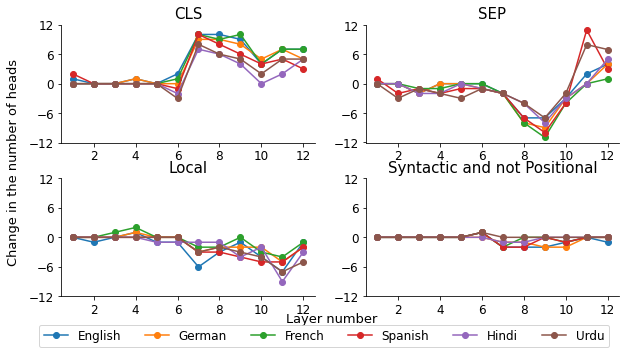

In [ ]:
#This cell plots the layer wise changes in number of heads for each functional role across the pivot languages after fine tuning on XNLI.

name={}
name['cls']='CLS'
name['sep']='SEP'
name['local']='Local'
name['syntactic']='Syntactic and not Positional'

funcs=['cls','sep','local']

languages=['english','german','french','spanish','hindi','urdu']

plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5))

plt.subplots_adjust(hspace=0.3)

for count,func in enumerate(funcs):
  axplot=ax[int(count/2)][count%2]
  for i in range(len(languages)):
      ftanalysisPath=analysisPath + 'XNLI/' + languages[i].title() + '/'
      df = pd.read_csv(ftanalysisPath + 'ChangeHeads' + languages[i].title() + 'XNLI.csv')
      changes=df[(df.Language==languages[i]) & (df.Role==func)]['Change'].to_numpy()
      axplot.plot(np.arange(1,13),changes,label=languages[i].title(),marker='o')
      axplot.spines['top'].set_visible(False)
      axplot.spines['right'].set_visible(False)
      
  axplot.tick_params(labelsize=12)   
  axplot.set_xticks(np.arange(2,13,2))
  axplot.set_yticks(np.arange(-12,13,6))
  axplot.set_title(name[func],{'fontsize':15})
  #axplot.set_xlabel('Layer number',{'fontsize':13})   
  #axplot.grid()

funcs=['syntactic']

languages=['english','german','french','spanish','hindi','urdu']

axplot=ax[int((count+1)/2)][(count+1)%2]

for func in funcs:
  for i in range(len(languages)):
      ftanalysisPath=analysisPath + 'XNLI/' + languages[i].title() + '/'
      df = pd.read_csv(ftanalysisPath + 'ChangeHeadsSyntactic' + languages[i].title() + 'XNLI.csv')
      changes=df[(df.Language==languages[i]) & (df.Role==func)]['Change'].to_numpy()
      axplot.plot(np.arange(1,13),changes,label=languages[i].title(),marker='o')
      axplot.spines['top'].set_visible(False)
      axplot.spines['right'].set_visible(False)
      
  axplot.tick_params(labelsize=12)   
  axplot.set_xticks(np.arange(2,13,2))
  axplot.set_yticks(np.arange(-12,13,6))
  axplot.set_title(name[func],{'fontsize':15})  
  #axplot.set_xlabel('Layer number',{'fontsize':13})     
  #axplot.grid()

handles, labels = axplot.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',fontsize='large',ncol=6,bbox_to_anchor=(0.45, -0.015))
fig.text(0.05, 0.5,'Change in the number of heads', {'fontsize':13}, va='center', rotation='vertical')
fig.text(0.5, 0.053, 'Layer number', {'fontsize':13}, ha='center')

fig.show()
#fig.savefig(analysisPath + 'Plots/FineTunedXNLI/' + 'All' + '.pdf', dpi=1200, format='pdf',bbox_inches = "tight")

**Plot for change in heads for each functional role(same task - XNLI English, Cross lingual)**

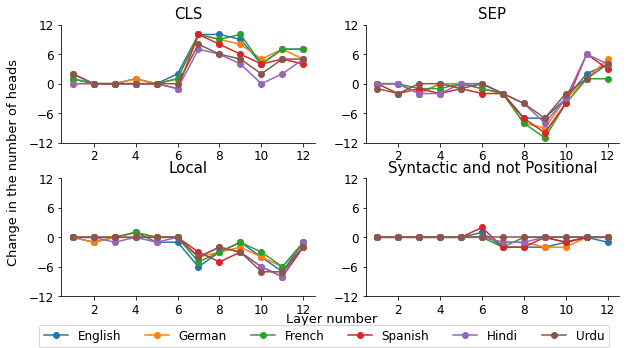

In [ ]:
#This cell plots the layer wise changes in number of heads for each functional role across the languages after fine tuning on XNLI English.

funcs=['cls','sep','local']

languages=['english','german','french','spanish','hindi','urdu']

name={}
name['cls']='CLS'
name['sep']='SEP'
name['local']='Local'
name['syntactic']='Syntactic and not Positional'

plt.rcParams["font.family"] = "Times New Roman"

ftanalysisPath=analysisPath + 'XNLI/English/'
df = pd.read_csv(ftanalysisPath + 'ChangeHeadsEnglishXNLI.csv')

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5))

plt.subplots_adjust(hspace=0.3)

for count,func in enumerate(funcs):
  axplot=ax[int(count/2)][count%2]
  for i in range(len(languages)):
      changes=df[(df.Language==languages[i]) & (df.Role==func)]['Change'].to_numpy()
      axplot.plot(np.arange(1,13),changes,label=languages[i].title(),marker='o')
      axplot.spines['top'].set_visible(False)
      axplot.spines['right'].set_visible(False)

  axplot.tick_params(labelsize=12)   
  axplot.set_xticks(np.arange(2,13,2))
  axplot.set_yticks(np.arange(-12,13,6))
  axplot.set_title(name[func],{'fontsize':15})
  #axplot.set_xlabel('Layer number',{'fontsize':15})    
  #axplot.grid()

func='syntactic'

ftanalysisPath=analysisPath + 'XNLI/English/'
df = pd.read_csv(ftanalysisPath + 'ChangeHeadsSyntacticEnglishXNLI.csv')

axplot=ax[int((count+1)/2)][(count+1)%2]

for i in range(len(languages)):
  changes=df[(df.Language==languages[i]) & (df.Role==func)]['Change'].to_numpy()
  axplot.plot(np.arange(1,13),changes,label=languages[i].title(),marker='o')
  axplot.spines['top'].set_visible(False)
  axplot.spines['right'].set_visible(False)

axplot.tick_params(labelsize=12)   
axplot.set_xticks(np.arange(2,13,2))
axplot.set_yticks(np.arange(-12,13,6))
axplot.set_title(name[func],{'fontsize':15})    
#axplot.set_xlabel('Layer number',{'fontsize':15})  
#axplot.grid()

handles, labels = axplot.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',fontsize='large',ncol=6,bbox_to_anchor=(0.45, -0.015))
fig.text(0.05, 0.5,'Change in the number of heads', {'fontsize':13}, va='center', rotation='vertical')
fig.text(0.5, 0.053, 'Layer number', {'fontsize':13}, ha='center')
fig.show()
#fig.savefig(analysisPath + 'Plots/CrossLingualXNLI/' + 'All' + '.pdf', dpi=1200, format='pdf',bbox_inches = "tight")

**Plot for change in heads for each functional role (same language - English)**

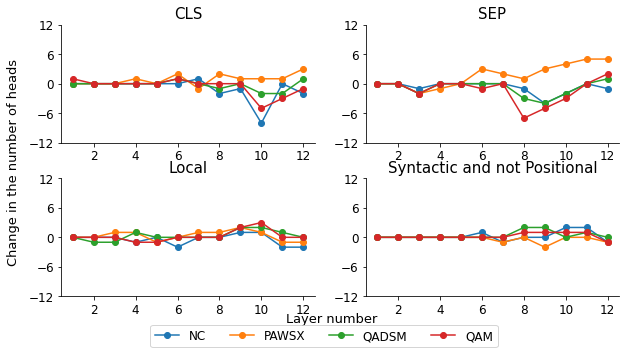

In [ ]:
#This cell plots the layer wise changes in number of heads for each functional role in English after fine tuning on different tasks.

funcs=['cls','sep','local']

tasks=['NC','PAWSX','QADSM','QAM']

name={}
name['cls']='CLS'
name['sep']='SEP'
name['local']='Local'
name['syntactic']='Syntactic and not Positional'

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5))

plt.subplots_adjust(hspace=0.3)

for count,func in enumerate(funcs):
  axplot=ax[int(count/2)][count%2]
  for i in range(len(tasks)):
      ftanalysisPath=analysisPath + tasks[i] + '/English/'
      df = pd.read_csv(ftanalysisPath + 'ChangeHeadsEnglish' + tasks[i] + '.csv')
      changes=df[(df.Language=='english') & (df.Role==func)]['Change'].to_numpy()
      axplot.plot(np.arange(1,13),changes,label=tasks[i].title(),marker='o')
      axplot.spines['top'].set_visible(False)
      axplot.spines['right'].set_visible(False)
      
  axplot.tick_params(labelsize=12)   
  axplot.set_xticks(np.arange(2,13,2))
  axplot.set_yticks(np.arange(-12,13,6))
  axplot.set_title(name[func],{'fontsize':15})
  #axplot.set_xlabel('Layer number',{'fontsize':15})    
  #axplot.grid()

funcs=['syntactic']

tasks=['NC','PAWSX','QADSM','QAM']

axplot=ax[int((count+1)/2)][(count+1)%2]

for func in funcs:
  for i in range(len(tasks)):
      ftanalysisPath=analysisPath + tasks[i] + '/English/'
      df = pd.read_csv(ftanalysisPath + 'ChangeHeadsSyntacticEnglish' + tasks[i] + '.csv')
      changes=df[(df.Language=='english') & (df.Role==func)]['Change'].to_numpy()
      axplot.plot(np.arange(1,13),changes,label=tasks[i],marker='o')
      
  axplot.tick_params(labelsize=12)   
  axplot.set_xticks(np.arange(2,13,2))
  axplot.set_yticks(np.arange(-12,13,6))
  axplot.set_title(name[func],{'fontsize':15})    
  axplot.spines['top'].set_visible(False)
  axplot.spines['right'].set_visible(False)
  #axplot.set_xlabel('Layer number',{'fontsize':13})  
  #axplot.grid()

handles, labels = axplot.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',fontsize='large',ncol=6,bbox_to_anchor=(0.45, -0.015))
fig.text(0.05, 0.5,'Change in the number of heads', {'fontsize':13}, va='center', rotation='vertical')
fig.text(0.5, 0.053, 'Layer number', {'fontsize':13}, ha='center')
fig.show()
#fig.savefig(analysisPath + 'Plots/FineTunedEnglish/' + 'All' + '.pdf', dpi=1200, format='pdf',bbox_inches = "tight")

**Common positional heads across languages in the pretrained model**

In [ ]:
languages=['hindi','urdu']

languages=['english','german','french','spanish','hindi','urdu']

functions=['cls','sep','local']

avg=0

common=set()

for i in range(len(languages)):
  posHeads=set()
  for k in functions:
    with open(ptweightsPath + languages[i]+ '-matrix-' + k + '-1000.pl', 'rb') as f:
        headSentScores=pickle.load(f)

    heads=[]
    for p in range(1,145):
        s=statistics.stdev(headSentScores[p])
        m=statistics.mean(headSentScores[p])
        t=(m-threshold)/(s/math.sqrt(n))
        pval=stats.t.sf(t, n-1)
        if(pval<0.05):
          heads.append(p)

    if (len(posHeads)==0):
      posHeads.update(heads)
    else:
      posHeads=posHeads.union(set(heads))

  avg+=len(posHeads)
  
  if (i==0):
    common.update(posHeads)
  else:
    common=common.intersection(posHeads)

print(sorted(common))
print(len(common))
print(round(avg/len(languages)))

[1, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 64, 65, 69, 70, 71, 73, 74, 75, 78, 80, 81, 82, 83, 84, 85, 86, 89, 92, 93, 94, 96, 97, 98, 101, 102, 104, 105, 108, 109, 110, 112, 115, 116, 117, 118, 119, 121, 123, 124, 125, 126, 127, 130, 131, 132, 133, 134, 136, 138, 139, 140, 141, 143, 144]
109
125


**Common unskilled heads across languages in the pretrained model**

In [ ]:
languages=['english','german','french','spanish','hindi','urdu']

functions=['cls','sep','local','nsubj','amod','advmod','obj']

avg=0

common=set()

for i in range(len(languages)):
  synHeads=set()
  for k in functions:
    with open(ptweightsPath + languages[i]+ '-matrix-' + k + '-1000.pl', 'rb') as f:
        headSentScores=pickle.load(f)

    heads=[]
    for p in range(1,145):
        s=statistics.stdev(headSentScores[p])
        m=statistics.mean(headSentScores[p])
        t=(m-threshold)/(s/math.sqrt(n))
        pval=stats.t.sf(t, n-1)
        if(pval<0.05):
          heads.append(p)

    if (len(synHeads)==0):
      synHeads.update(heads)
    else:
      synHeads=synHeads.union(set(heads))

  unskilledHeads=set(np.arange(1,145))-set(synHeads)
  avg+=len(unskilledHeads)
  
  if (i==0):
    common.update(unskilledHeads)
  else:
    common=common.intersection(unskilledHeads)

print(sorted(common))
print(len(common))
print(round(avg/len(languages)))

[3, 11, 12, 87, 106, 129]
6
14


**Common syntactic non positional heads across languages in the pretrained model**

In [ ]:
languages=['english','german','french','spanish','hindi','urdu']

functionspos=['cls','sep','local']

functionssyn=['nsubj','amod','advmod','obj']

avg=0

common=set()

for i in range(len(languages)):
  posHeads=set()
  for k in functionspos:
    with open(ptweightsPath + languages[i]+ '-matrix-' + k + '-1000.pl', 'rb') as f:
        headSentScores=pickle.load(f)

    heads=[]
    for p in range(1,145):
        s=statistics.stdev(headSentScores[p])
        m=statistics.mean(headSentScores[p])
        t=(m-threshold)/(s/math.sqrt(n))
        pval=stats.t.sf(t, n-1)
        if(pval<0.05):
          heads.append(p)

    if (len(posHeads)==0):
      posHeads.update(heads)
    else:
      posHeads=posHeads.union(set(heads))

  synHeads=set()
  for k in functionssyn:
    with open(ptweightsPath + languages[i]+ '-matrix-' + k + '-1000.pl', 'rb') as f:
        headSentScores=pickle.load(f)

    heads=[]
    for p in range(1,145):
        s=statistics.stdev(headSentScores[p])
        m=statistics.mean(headSentScores[p])
        t=(m-threshold)/(s/math.sqrt(n))
        pval=stats.t.sf(t, n-1)
        if(pval<0.05):
          if(p not in posHeads):
            heads.append(p)

    if (len(synHeads)==0):
      synHeads.update(heads)
    else:
      synHeads=synHeads.union(set(heads))

  avg+=len(synHeads)
  
  if (i==0):
    common.update(synHeads)
  else:
    common=common.intersection(synHeads)

print(sorted(common))
print(len(common))
print(round(avg/len(languages)))

[]
0
5


**Common positional heads across languages in the FT models on XNLI**

In [ ]:
languages=['english','german','french','spanish','hindi','urdu']

functions=['cls','sep','local']

avg=0

threshold=3

common=set()

for i in range(len(languages)):
  synHeads=set()
  for k in functions:
    with open(ftweightsPath + languages[i].title()+ '/' + languages[i] + '-matrix-' + k + '-ft-1000.pl', 'rb') as f:
        headSentScores=pickle.load(f)

    heads=[]
    for p in range(1,145):
        s=statistics.stdev(headSentScores[p])
        m=statistics.mean(headSentScores[p])
        t=(m-threshold)/(s/math.sqrt(n))
        pval=stats.t.sf(t, n-1)
        if(pval<0.05):
          heads.append(p)

    if (len(synHeads)==0):
      synHeads.update(heads)
    else:
      synHeads=synHeads.union(set(heads))

  avg+=len(synHeads)
  
  if (i==0):
    common.update(synHeads)
  else:
    common=common.intersection(synHeads)

print(sorted(common))
print(len(common))
print(round(avg/len(languages)))

[1, 2, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 64, 65, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144]
133
137


**Common unskilled heads across languages in the FT models on XNLI**

In [ ]:
languages=['english','german','french','spanish','hindi','urdu']

functions=['cls','sep','local','nsubj','amod','advmod','obj']

avg=0

common=set()

for i in range(len(languages)):
  synHeads=set()
  for k in functions:
    with open(ftweightsPath + languages[i].title()+ '/' + languages[i] + '-matrix-' + k + '-ft-1000.pl', 'rb') as f:
        headSentScores=pickle.load(f)

    heads=[]
    for p in range(1,145):
        s=statistics.stdev(headSentScores[p])
        m=statistics.mean(headSentScores[p])
        t=(m-threshold)/(s/math.sqrt(n))
        pval=stats.t.sf(t, n-1)
        if(pval<0.05):
          heads.append(p)

    if (len(synHeads)==0):
      synHeads.update(heads)
    else:
      synHeads=synHeads.union(set(heads))

  unskilledHeads=set(np.arange(1,145))-set(synHeads)
  avg+=len(unskilledHeads)
  
  if (i==0):
    common.update(unskilledHeads)
  else:
    common=common.intersection(unskilledHeads)

print(sorted(common))
print(len(common))
print(round(avg/len(languages)))

[3, 11, 12]
3
6


**Common syntactic non positional heads across languages in the FT models on XNLI**

In [ ]:
languages=['english','german','french','spanish','hindi','urdu']

functionspos=['cls','sep','local']

functionssyn=['nsubj','amod','advmod','obj']

avg=0

common=set()

for i in range(len(languages)):
  posHeads=set()
  for k in functionspos:
    with open(ftweightsPath + languages[i].title()+ '/' + languages[i] + '-matrix-' + k + '-ft-1000.pl', 'rb') as f:
        headSentScores=pickle.load(f)

    heads=[]
    for p in range(1,145):
        s=statistics.stdev(headSentScores[p])
        m=statistics.mean(headSentScores[p])
        t=(m-threshold)/(s/math.sqrt(n))
        pval=stats.t.sf(t, n-1)
        if(pval<0.05):
          heads.append(p)

    if (len(posHeads)==0):
      posHeads.update(heads)
    else:
      posHeads=posHeads.union(set(heads))

  synHeads=set()
  for k in functionssyn:
    with open(ftweightsPath + languages[i].title()+ '/' + languages[i] + '-matrix-' + k + '-ft-1000.pl', 'rb') as f:
        headSentScores=pickle.load(f)

    heads=[]
    for p in range(1,145):
        s=statistics.stdev(headSentScores[p])
        m=statistics.mean(headSentScores[p])
        t=(m-threshold)/(s/math.sqrt(n))
        pval=stats.t.sf(t, n-1)
        if(pval<0.05):
          if(p not in posHeads):
            heads.append(p)

    if (len(synHeads)==0):
      synHeads.update(heads)
    else:
      synHeads=synHeads.union(set(heads))

  avg+=len(synHeads)
  
  if (i==0):
    common.update(synHeads)
  else:
    common=common.intersection(synHeads)

print(sorted(common))
print(len(common))
print(round(avg/len(languages)))

[]
0
2


**Common positional heads across languages in the FT model on XNLI English - Cross Lingual**

In [ ]:
languages=['english','german','french','spanish','hindi','urdu']

functions=['cls','sep','local']

avg=0

threshold=3

common=set()

for i in range(len(languages)):
  synHeads=set()
  for k in functions:
    with open(ftweightsPath + 'English/' + languages[i] + '-matrix-' + k + '-ft-1000.pl', 'rb') as f:
        headSentScores=pickle.load(f)

    heads=[]
    for p in range(1,145):
        s=statistics.stdev(headSentScores[p])
        m=statistics.mean(headSentScores[p])
        t=(m-threshold)/(s/math.sqrt(n))
        pval=stats.t.sf(t, n-1)
        if(pval<0.05):
          heads.append(p)

    if (len(synHeads)==0):
      synHeads.update(heads)
    else:
      synHeads=synHeads.union(set(heads))

  avg+=len(synHeads)
  
  if (i==0):
    common.update(synHeads)
  else:
    common=common.intersection(synHeads)

print(sorted(common))
print(len(common))
print(round(avg/len(languages)))

[2, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144]
134
137


**Common syntactic non positional heads across languages in the FT model on XNLI English - Cross Lingual**

In [ ]:
languages=['english','german','french','spanish','hindi','urdu']

functionspos=['cls','sep','local']

functionssyn=['nsubj','amod','advmod','obj']

avg=0

common=set()

for i in range(len(languages)):
  posHeads=set()
  for k in functionspos:
    with open(ftweightsPath + 'English/' + languages[i] + '-matrix-' + k + '-ft-1000.pl', 'rb') as f:
        headSentScores=pickle.load(f)

    heads=[]
    for p in range(1,145):
        s=statistics.stdev(headSentScores[p])
        m=statistics.mean(headSentScores[p])
        t=(m-threshold)/(s/math.sqrt(n))
        pval=stats.t.sf(t, n-1)
        if(pval<0.05):
          heads.append(p)

    if (len(posHeads)==0):
      posHeads.update(heads)
    else:
      posHeads=posHeads.union(set(heads))

  synHeads=set()
  for k in functionssyn:
    with open(ftweightsPath + 'English/' + languages[i] + '-matrix-' + k + '-ft-1000.pl', 'rb') as f:
        headSentScores=pickle.load(f)

    heads=[]
    for p in range(1,145):
        s=statistics.stdev(headSentScores[p])
        m=statistics.mean(headSentScores[p])
        t=(m-threshold)/(s/math.sqrt(n))
        pval=stats.t.sf(t, n-1)
        if(pval<0.05):
          if(p not in posHeads):
            heads.append(p)

    if (len(synHeads)==0):
      synHeads.update(heads)
    else:
      synHeads=synHeads.union(set(heads))

  avg+=len(synHeads)
  
  if (i==0):
    common.update(synHeads)
  else:
    common=common.intersection(synHeads)

print(sorted(common))
print(len(common))
print(round(avg/len(languages)))

[]
0
1


**Parallel plots after fine tuning on XNLI (same task, across languages)**

In [ ]:
#This cell draws the parallel plots for each of the pivot languages after fine tuning on XNLI. We see that the parallel plots show the same structure for 
#all languages which aligns with the high correlation scores.

name={}
name['cls']='CLS'
name['sep']='SEP'
name['local']='Local'
name['positional']='Positional'
name['syntactic']='Syntactic'

languages=['english']

functions=['cls','sep','local','nsubj','amod','advmod','obj']

for lang in languages:

  rolespt=[set() for i in range(145)]
  rolesft=[set() for i in range(145)]

  for func in functions:
    with open(ptweightsPath + lang + '-matrix-' + func + '-1000.pl', 'rb') as f:
            headSentScorespt=pickle.load(f)

    with open(ftweightsPath + lang.title() + '/' + lang + '-matrix-' + func + '-ft-1000.pl', 'rb') as f:
            headSentScoresft=pickle.load(f)
    
    for p in range(1,145):
      s=statistics.stdev(headSentScorespt[p])
      m=statistics.mean(headSentScorespt[p])
      t=(m-threshold)/(s/math.sqrt(n))
      pval=stats.t.sf(t, n-1)
      if(pval<0.05):
        if (func in ['cls','sep','local']):
          rolespt[p].add('positional')
        else:
          if('positional' not in rolespt[p]):
            rolespt[p].add('syntactic')
      s=statistics.stdev(headSentScoresft[p])
      m=statistics.mean(headSentScoresft[p])
      t=(m-threshold)/(s/math.sqrt(n))
      pval=stats.t.sf(t, n-1)
      if(pval<0.05):
        if (func in ['cls','sep','local']):
          rolesft[p].add('positional')
        else:
          if('positional' not in rolesft[p]):
            rolesft[p].add('syntactic')

  df=pd.DataFrame(columns=['PT','FT','Layer','Head'])
  count=0   
  for p in range(1,145):
    layer=math.ceil(p/12)
    if len(rolespt[p])==0 and len(rolesft[p])==0:
      df.loc[count]=['Unskilled','Unskilled',layer,p]
    else:
      if len(rolespt[p])!=0 and len(rolesft[p])!=0:
        old=list(rolespt[p])[0]
        new=list(rolesft[p])[0]
        df.loc[count]=[name[old],name[new],layer,p]
      elif len(rolespt[p])!=0:
        old=list(rolespt[p])[0]
        df.loc[count]=[name[old],'Unskilled',layer,p]
      elif len(rolesft[p])!=0:
        new=list(rolesft[p])[0]
        df.loc[count]=['Unskilled',name[new],layer,p]
    count+=1

  nonedf=df.loc[(df['PT']==df['FT']) & (df['PT']=='Unskilled')]
  positionaldf=df.loc[(df['PT']==df['FT']) & (df['PT']==name['positional'])]
  syndf=df.loc[(df['PT']==df['FT']) & (df['PT']==name['syntactic'])]
  if (syndf.empty):
    syndf=df.loc[df['PT']==name['syntactic']]
    diffdf=df.loc[(df['PT']!=df['FT']) & (df['PT']!=name['syntactic'])]
  else:
    diffdf=df.loc[df['PT']!=df['FT']]
  df=positionaldf.append(syndf).append(nonedf).append(diffdf)
  fig = px.parallel_categories(
      df, dimensions=['PT', 'FT'], color='Layer', 
      labels={'PT':'Pre Trained','FT': 'Fine Tuned'},
      color_continuous_scale=px.colors.sequential.Inferno
      )
  fig.update_layout(
      font_family="Times New Roman",
      autosize=False,
      width=700,
      height=500,font=dict(size=15))
  #fig.update(layout_coloraxis_showscale=False)
  fig.update_layout(coloraxis_colorbar=dict(
    yanchor="top", y=1,
    ticks="outside",xpad=60,ypad=50
))
  fig.show()

  #fig.write_image(analysisPath + 'Plots/FineTunedXNLI/' + 'Parallel' + lang.title() + '.pdf')

**Pie chart for the roles in pretrained model**

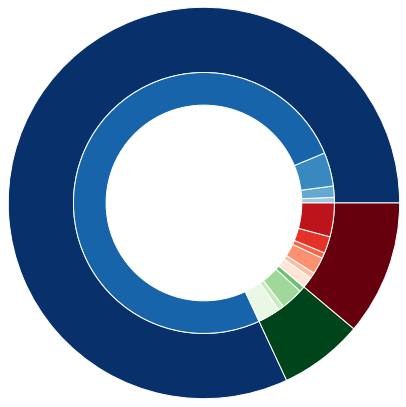

In [ ]:
#This cell plots the pie charts of the proportion of each category in the outer ring and the inner ring contains numbers for groups of 1 to 6 languages.

import itertools

languagesInitial=['english']

fig, ax = plt.subplots(figsize=(3,3))

plt.subplots_adjust(wspace=5)

functionspos=['cls','sep','local']

functionssyn=['nsubj','amod','advmod','obj']

functions=['cls','sep','local','nsubj','amod','advmod','obj']

for countl,language in enumerate(languagesInitial):

  avg=0

  common=set()

  posHeads=set()
  for k in functionspos:
    with open(ptweightsPath + language + '-matrix-' + k + '-1000.pl', 'rb') as f:
        headSentScores=pickle.load(f)

    heads=[]
    for p in range(1,145):
        s=statistics.stdev(headSentScores[p])
        m=statistics.mean(headSentScores[p])
        t=(m-threshold)/(s/math.sqrt(n))
        pval=stats.t.sf(t, n-1)
        if(pval<0.05):
          heads.append(p)

    if (len(posHeads)==0):
      posHeads.update(heads)
    else:
      posHeads=posHeads.union(set(heads))

  synHeads=set()
  for k in functionssyn:
    with open(ptweightsPath + language + '-matrix-' + k + '-1000.pl', 'rb') as f:
        headSentScores=pickle.load(f)

    heads=[]
    for p in range(1,145):
        s=statistics.stdev(headSentScores[p])
        m=statistics.mean(headSentScores[p])
        t=(m-threshold)/(s/math.sqrt(n))
        pval=stats.t.sf(t, n-1)
        if(pval<0.05):
          if(p not in posHeads):
            heads.append(p)

    if (len(synHeads)==0):
      synHeads.update(heads)
    else:
      synHeads=synHeads.union(set(heads))

  avg+=len(synHeads)

  unskilledHeads=set(np.arange(1,145)) - synHeads.union(posHeads)

  languages=['english','german','french','spanish','hindi','urdu']

  freqPos={}
  freqSyn={}
  freqUns={}
  for i in range(1,145):
    freqPos[i]=0
    freqSyn[i]=0
    freqUns[i]=0
  for lang in languages:
    posHeadsAll=set()
    for k in functionspos:
      with open(ptweightsPath + lang + '-matrix-' + k + '-1000.pl', 'rb') as f:
          headSentScores=pickle.load(f)

      heads=[]
      for p in range(1,145):
          s=statistics.stdev(headSentScores[p])
          m=statistics.mean(headSentScores[p])
          t=(m-threshold)/(s/math.sqrt(n))
          pval=stats.t.sf(t, n-1)
          if(pval<0.05):
            heads.append(p)

      if (len(posHeadsAll)==0):
        posHeadsAll.update(heads)
      else:
        posHeadsAll=posHeadsAll.union(set(heads))

    for head in posHeadsAll:
      freqPos[head]+=1

    synHeadsAll=set()
    for k in functionssyn:
      with open(ptweightsPath + lang + '-matrix-' + k + '-1000.pl', 'rb') as f:
          headSentScores=pickle.load(f)

      heads=[]
      for p in range(1,145):
          s=statistics.stdev(headSentScores[p])
          m=statistics.mean(headSentScores[p])
          t=(m-threshold)/(s/math.sqrt(n))
          pval=stats.t.sf(t, n-1)
          if(pval<0.05):
            if(p not in posHeadsAll):
              heads.append(p)

      if (len(synHeadsAll)==0):
        synHeadsAll.update(heads)
      else:
        synHeadsAll=synHeadsAll.union(set(heads))

    for head in synHeadsAll:
      freqSyn[head]+=1

  for lang in languages:
    freq={}
    for i in range(1,145):
      freq[i]=0
    for func in functions:
      with open(ptweightsPath + lang + '-matrix-' + func + '-1000.pl', 'rb') as f:
            headSentScores=pickle.load(f)

      heads=[]
      for p in range(1,145):
          s=statistics.stdev(headSentScores[p])
          m=statistics.mean(headSentScores[p])
          t=(m-threshold)/(s/math.sqrt(n))
          pval=stats.t.sf(t, n-1)
          if(pval<0.05):
            heads.append(p)

      for head in heads:
        freq[head]+=1
    
    skilledHeadsAll=[key for key,value in freq.items() if value>=1]
    unSkilledHeadsAll=set(np.arange(1,145)) - set(skilledHeadsAll)
    for head in unSkilledHeadsAll:
      freqUns[head]+=1

  countsPos=[]
  countsSyn=[]
  countsUns=[]
  for i in range(1,7):
    countsPos.append(set([key for key,value in freqPos.items() if value==i]))
    countsSyn.append(set([key for key,value in freqSyn.items() if value==i]))
    countsUns.append(set([key for key,value in freqUns.items() if value==i]))

  intersectionsPos=[]
  intersectionsSyn=[]
  intersectionsUns=[]
  for i in range(6):
    intersectionsPos.append(len(countsPos[i].intersection(posHeads)))
    intersectionsSyn.append(len(countsSyn[i].intersection(synHeads)))
    intersectionsUns.append(len(countsUns[i].intersection(unskilledHeads)))

  plt.rcParams['font.size'] = 25
  plt.rcParams["font.family"] = "Times New Roman"

  cmap1 = plt.cm.Blues
  cmap2 = plt.cm.Greens
  cmap3 = plt.cm.Reds
  inner_colors = [*cmap1(np.linspace(.1, .8, 6)),
                  *cmap2(np.linspace(.1, .8, 6)),
                  *cmap3(np.linspace(.1, .8, 6))]

  sublabels=['z'] * 18
  wedges, texts = ax.pie([len(posHeads),len(synHeads),len(unskilledHeads)],radius=3,colors=[cmap1(1.),cmap2(1.),cmap3(1.)],wedgeprops=dict(width=1, edgecolor='w'))
  pie2, text2 = ax.pie(list(itertools.chain(intersectionsPos, intersectionsSyn, intersectionsUns)),colors=inner_colors,radius=2,labels=sublabels,wedgeprops=dict(width=0.5, edgecolor='w'))
  for t in text2:
      t.remove()

fig.show()

#fig.savefig(analysisPath + 'Plots/PreTrained/' + 'pie' + language.title() + '.pdf', dpi=1200, format='pdf',bbox_inches = "tight")

**Pie charts with language groupings in pretrained model**

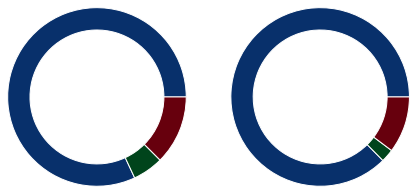

In [ ]:
#This cell plots two pie charts for each language family, the first one shows the average no: of heads of a specific role across the pair of languages, the
#second one shows the no: of common heads of a specific role across the languages. 

import itertools

languages=['english','german']

fig, ax = plt.subplots(1,2,figsize=(5,5))

plt.subplots_adjust(wspace=3)

functionspos=['cls','sep','local']

functionssyn=['nsubj','amod','advmod','obj']

functions=['cls','sep','local','nsubj','amod','advmod','obj']

avgpos=0
avgsyn=0
avguns=0

commonpos=set()
commonsyn=set()
commonuns=set()

for countl,language in enumerate(languages):

  avg=0

  posHeads=set()
  for k in functionspos:
    with open(ptweightsPath + language + '-matrix-' + k + '-1000.pl', 'rb') as f:
        headSentScores=pickle.load(f)

    heads=[]
    for p in range(1,145):
        s=statistics.stdev(headSentScores[p])
        m=statistics.mean(headSentScores[p])
        t=(m-threshold)/(s/math.sqrt(n))
        pval=stats.t.sf(t, n-1)
        if(pval<0.05):
          heads.append(p)

    if (len(posHeads)==0):
      posHeads.update(heads)
    else:
      posHeads=posHeads.union(set(heads))

  if (len(commonpos)==0):
    commonpos.update(posHeads)
  else:
    commonpos=commonpos.intersection(posHeads)
    
  avgpos+=len(posHeads)

  synHeads=set()
  for k in functionssyn:
    with open(ptweightsPath + language + '-matrix-' + k + '-1000.pl', 'rb') as f:
        headSentScores=pickle.load(f)

    heads=[]
    for p in range(1,145):
        s=statistics.stdev(headSentScores[p])
        m=statistics.mean(headSentScores[p])
        t=(m-threshold)/(s/math.sqrt(n))
        pval=stats.t.sf(t, n-1)
        if(pval<0.05):
          if(p not in posHeads):
            heads.append(p)

    if (len(synHeads)==0):
      synHeads.update(heads)
    else:
      synHeads=synHeads.union(set(heads))

  if (len(commonsyn)==0):
    commonsyn.update(synHeads)
  else:
    commonsyn=commonsyn.intersection(synHeads)

  avgsyn+=len(synHeads)

  unskilledHeads=set(np.arange(1,145)) - synHeads.union(posHeads)

  if (len(commonuns)==0):
    commonuns.update(unskilledHeads)
  else:
    commonuns=commonuns.intersection(unskilledHeads)

  avguns+=len(unskilledHeads)

plt.rcParams['font.size'] = 25
plt.rcParams["font.family"] = "Times New Roman"

cmap1 = plt.cm.Blues
cmap2 = plt.cm.Greens
cmap3 = plt.cm.Reds
inner_colors = [*cmap1(np.linspace(.1, .8, 6)),
                *cmap2(np.linspace(.1, .8, 6)),
                *cmap3(np.linspace(.1, .8, 6))]

pos=round(avgpos/len(languages))
syn=round(avgsyn/len(languages))
uns=round(avguns/len(languages))
wedges, texts = ax[0].pie([pos,syn,uns],radius=4,colors=[cmap1(1.),cmap2(1.),cmap3(1.)],wedgeprops=dict(width=1, edgecolor='w'))
wedges, texts = ax[1].pie([len(commonpos),len(commonsyn),len(commonuns)],radius=4,colors=[cmap1(1.),cmap2(1.),cmap3(1.)],wedgeprops=dict(width=1, edgecolor='w'))
fig.show()

#fig.savefig(analysisPath + 'Plots/PreTrained/' + 'pieAryan.png', dpi=1200, format='png',bbox_inches = "tight")

**Jensen-Shannon Divergence between attention distributions of heads**

In [ ]:
# This and the subsequent cells computes the JS Divergence between the attention distribtuions of heads. It then uses MDS to project down to
#2D space to visualize the distances between heads.
in_file=open('/content/drive/My Drive/MTP/Datasets/english-sentences-1000.txt','r',encoding='utf-8')

lines=in_file.readlines()

tokenizer=transformers.BertTokenizer.from_pretrained('bert-base-multilingual-cased')

bert_model = transformers.BertModel.from_pretrained('bert-base-multilingual-cased', output_attentions=True)

class SentenceDataset(Dataset):
  
  def __init__(self, sentences,tokenizer,max_len):
    self.sentences=sentences
    self.tokenizer=tokenizer
    self.max_len=max_len

  def __len__(self):
    return len(self.sentences)

  def __getitem__(self,item):
    sentence=str(self.sentences[item])

    encoding=tokenizer.encode_plus(
        sentence,
        max_length=self.max_len,
        add_special_tokens=True,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_token_type_ids=False,
        truncation=True,
        return_tensors='pt'
    )

    return{
        'sentence':sentence,
        'input_ids':encoding['input_ids'],
        'attention_mask':encoding['attention_mask']
    }

MAX_LEN=64
BATCH_SIZE=8

def create_data_loader(sentences,tokenizer,max_len,batch_size):
  ds= SentenceDataset(
      sentences=sentences,
      tokenizer=tokenizer,
      max_len=max_len
  )

  return DataLoader(
      ds,
      batch_size=batch_size
  )


data_loader=create_data_loader(lines[:10],tokenizer,MAX_LEN,BATCH_SIZE)

attentionHeads = np.array([[[[0 for i in range(64)] for j in range(64)] for k in range(145)] for l in range(len(data_loader.dataset))],dtype=float)

counts=np.array([0 for i in range(len(data_loader.dataset))])

for count, data in enumerate(iter(data_loader)):
  last_hidden_state,pooler_output, attentions = bert_model(input_ids=torch.squeeze(data['input_ids']),attention_mask=torch.squeeze(data['attention_mask']),return_dict=False)
  for attention_id, attention in enumerate(attentions):
    for element in range(attention.shape[0]):
      for head in range(attention.shape[1]):
        number = attention_id * 12 + (head+1)
        tokens = tokenizer.tokenize(lines[count * BATCH_SIZE + element])
        final_tokens = ['CLS'] + tokens[:62] + ['SEP']
        sent_len = len(final_tokens)
        counts[count * BATCH_SIZE + element]=sent_len
        attentionHeads[count * BATCH_SIZE + element][number]=attention[element][head].detach().numpy()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [ ]:
js_distances=np.array([[0 for i in range(145)] for j in range(145)],dtype=float)

for l in range(len(data_loader.dataset)):
  for i in range(1,145):
    for j in range(1,145):
      sum=0
      for k in range(counts[l]):
        sum+=spatial.distance.jensenshannon(attentionHeads[l][i][k],attentionHeads[l][j][k])
      js_distances[i][j]+=(sum/counts[l])
  print(l)

for i in range(1,145):
    for j in range(1,145):
      js_distances[i][j]/=len(data_loader.dataset)
      
print(js_distances.shape)

0
1
2
3
4
5
6
7
8
9
(145, 145)


In [ ]:
colors=[]
for i in range(12):
  colors.append('cornflowerblue')

for i in range(12):
  colors.append('royalblue')

for i in range(12):
  colors.append('blue')

for i in range(12):
  colors.append('darkblue')

for i in range(12):
  colors.append('lightgreen')

for i in range(12):
  colors.append('lime')

for i in range(12):
  colors.append('forestgreen')

for i in range(12):
  colors.append('darkgreen')

for i in range(12):
  colors.append('lightcoral')

for i in range(12):
  colors.append('indianred')

for i in range(12):
  colors.append('red')

for i in range(12):
  colors.append('darkred')

(144, 2)


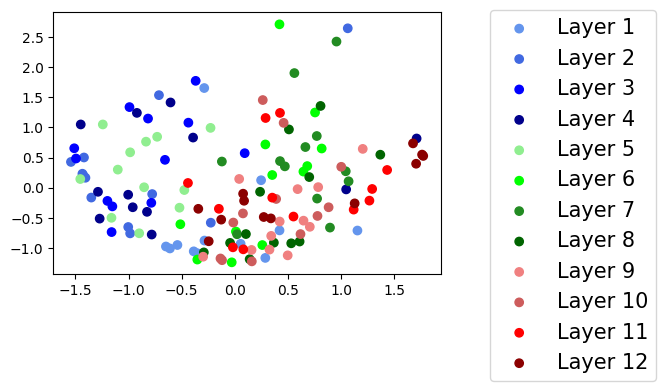

In [ ]:
embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(js_distances[1:145])
print(X_transformed.shape)
plt.style.use('default')
plt.rcParams['figure.figsize'] = [5,3.4]
plt.scatter(X_transformed[:12,0],X_transformed[:12,1],c=colors[:12],label='Layer 1')
plt.scatter(X_transformed[12:24,0],X_transformed[12:24,1],c=colors[12:24],label='Layer 2')
plt.scatter(X_transformed[24:36,0],X_transformed[24:36,1],c=colors[24:36],label='Layer 3')
plt.scatter(X_transformed[36:48,0],X_transformed[36:48,1],c=colors[36:48],label='Layer 4')
plt.scatter(X_transformed[48:60,0],X_transformed[48:60,1],c=colors[48:60],label='Layer 5')
plt.scatter(X_transformed[60:72,0],X_transformed[60:72,1],c=colors[60:72],label='Layer 6')
plt.scatter(X_transformed[72:84,0],X_transformed[72:84,1],c=colors[72:84],label='Layer 7')
plt.scatter(X_transformed[84:96,0],X_transformed[84:96,1],c=colors[84:96],label='Layer 8')
plt.scatter(X_transformed[96:108,0],X_transformed[96:108,1],c=colors[96:108],label='Layer 9')
plt.scatter(X_transformed[108:120,0],X_transformed[108:120,1],c=colors[108:120],label='Layer 10')
plt.scatter(X_transformed[120:132,0],X_transformed[120:132,1],c=colors[120:132],label='Layer 11')
plt.scatter(X_transformed[132:144,0],X_transformed[132:144,1],c=colors[132:144],label='Layer 12')
fig=plt.gcf()
plt.legend(bbox_to_anchor=(1.1, 1.05),fontsize=15)

**Average entropy of attention heads across layers**

In [ ]:
#This and the subsequent cells computes the average entropy of attention heads(blue dots) and the average entropy per layer(red line).

in_file=open('/content/drive/My Drive/MTP/Datasets/english-sentences-1000.txt','r',encoding='utf-8')

lines=in_file.readlines()

tokenizer=transformers.BertTokenizer.from_pretrained('bert-base-multilingual-cased')

bert_model = transformers.BertModel.from_pretrained('bert-base-multilingual-cased', output_attentions=True)

class SentenceDataset(Dataset):
  
  def __init__(self, sentences,tokenizer,max_len):
    self.sentences=sentences
    self.tokenizer=tokenizer
    self.max_len=max_len

  def __len__(self):
    return len(self.sentences)

  def __getitem__(self,item):
    sentence=str(self.sentences[item])

    encoding=tokenizer.encode_plus(
        sentence,
        max_length=self.max_len,
        add_special_tokens=True,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_token_type_ids=False,
        truncation=True,
        return_tensors='pt'
    )

    return{
        'sentence':sentence,
        'input_ids':encoding['input_ids'],
        'attention_mask':encoding['attention_mask']
    }

MAX_LEN=64
BATCH_SIZE=8

def create_data_loader(sentences,tokenizer,max_len,batch_size):
  ds= SentenceDataset(
      sentences=sentences,
      tokenizer=tokenizer,
      max_len=max_len
  )

  return DataLoader(
      ds,
      batch_size=batch_size
  )


data_loader=create_data_loader(lines[:50],tokenizer,MAX_LEN,BATCH_SIZE)

attentionHeads = np.array([[[[0 for i in range(64)] for j in range(64)] for k in range(145)] for l in range(len(data_loader.dataset))],dtype=float)

counts=np.array([0 for i in range(len(data_loader.dataset))])

for count, data in enumerate(iter(data_loader)):
  last_hidden_state,pooler_output, attentions = bert_model(input_ids=torch.squeeze(data['input_ids']),attention_mask=torch.squeeze(data['attention_mask']),return_dict=False)
  for attention_id, attention in enumerate(attentions):
    for element in range(attention.shape[0]):
      for head in range(attention.shape[1]):
        number = attention_id * 12 + (head+1)
        tokens = tokenizer.tokenize(lines[count * BATCH_SIZE + element])
        final_tokens = ['CLS'] + tokens[:62] + ['SEP']
        sent_len = len(final_tokens)
        counts[count * BATCH_SIZE + element]=sent_len
        attentionHeads[count * BATCH_SIZE + element][number]=attention[element][head].detach().numpy()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [ ]:
#Average Entropies from all tokens

entropies=np.array([0 for i in range(145)],dtype=float)

for i in range(1,145):
  for element in range(len(data_loader.dataset)):
    sum=0
    for k in range(counts[element]):
      sum+=stats.entropy(attentionHeads[element][i][k])
    entropies[i]+=sum/counts[element]

for i in range(1,145):
  entropies[i]/=len(data_loader.dataset)

avgEntropies=[]
for i in range(1,145,12):
  avgEntropies.append(entropies[i:i+12].sum()/12)

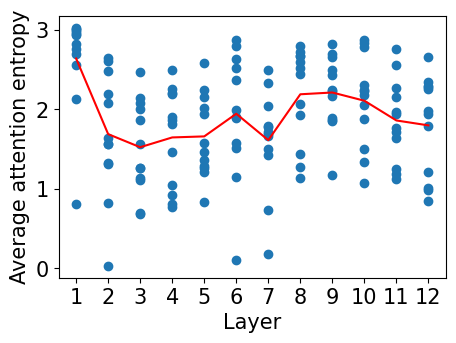

In [ ]:
layers=[1] * 12 + [2] * 12 + [3] * 12 + [4] * 12 + [5] * 12 + [6] * 12 + [7] * 12 + [8] * 12 + [9] * 12 + [10] * 12 + [11] * 12 + [12] * 12
plt.rcParams['figure.figsize'] = [5,3.4]
plt.rcParams['font.size'] = 15
plt.rcParams["font.family"] = "Times New Roman"
plt.scatter(layers,entropies[1:])
plt.plot(np.arange(1,13),avgEntropies,color='red')
plt.xticks(np.arange(1,13))
plt.xlabel('Layer')
plt.ylabel('Average attention entropy')
fig=plt.gcf()
plt.show()

In [ ]:
#This is to install the orca dependency for saving plotly images as PDFs.

!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get update
!apt-get install xvfb libgtk2.0-0 libgconf-2-4